In [ ]:
#pip install wetterdienst
#pip install polars
#pip install pandas
#pip install matplotlib
#pip install numpy

## 1) Data:
Titel: Tägliche Stationsmessungen Niederschlagshöhe in mm   
Kurzname: OBS_DEU_P1D_RR   
- [Data Source](https://dwd-geoportal.de/products/OBS_DEU_P1D_RR/ )
- [FTP-Server-Link](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/more_precip/recent/)


##### Easy access to data via ["wetterdienst"](https://pypi.org/project/wetterdienst/)-python library
- [Code examples #1](https://github.com/earthobservations/wetterdienst/tree/main/examples)
- [Code examples #2](https://www.geo.fu-berlin.de/en/v/soga-py/Advanced-statistics/Spatial-Interpolation/Data-sets-used/DWD-weather-data-East-Germany/index.html)


variables that are provided via wetterdienst: [Link](https://wetterdienst.readthedocs.io/en/latest/data/parameters.html)  

we are intersted in --> PRECIPITATION_HEIGHT --> the amount of rain for each day at each station in mm
  

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps

import polars as pl
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

from wetterdienst import Settings
from wetterdienst.provider.dwd.observation import (
    DwdObservationDataset,
    DwdObservationParameter,
    DwdObservationPeriod,
    DwdObservationRequest,
    DwdObservationResolution,
)

In [2]:
import polars as pl
_ = pl.Config.set_tbl_hide_dataframe_shape(True)
from wetterdienst import Settings
from wetterdienst.provider.dwd.observation import DwdObservationRequest

settings = Settings( # default
    ts_shape="long",  # tidy data
    ts_humanize=True,  # humanized parameters
    ts_si_units=True  # convert values to SI units
)

request = DwdObservationRequest(
   parameter=["PRECIPITATION_HEIGHT"],
   resolution="daily",
   start_date="1960-01-01",  # if not given timezone defaulted to UTC
   end_date="2023-12-31",  # if not given timezone defaulted to UTC
   settings=settings
).all()

# access the meta data of the staions
stations = request.df
print(stations.head())


# access the desired weather data
values = request.values.all().df
print(values.head())

┌────────────┬─────────────┬─────────────┬──────────┬───────────┬────────┬────────────┬────────────┐
│ station_id ┆ start_date  ┆ end_date    ┆ latitude ┆ longitude ┆ height ┆ name       ┆ state      │
│ ---        ┆ ---         ┆ ---         ┆ ---      ┆ ---       ┆ ---    ┆ ---        ┆ ---        │
│ str        ┆ datetime[μs ┆ datetime[μs ┆ f64      ┆ f64       ┆ f64    ┆ str        ┆ str        │
│            ┆ , UTC]      ┆ , UTC]      ┆          ┆           ┆        ┆            ┆            │
╞════════════╪═════════════╪═════════════╪══════════╪═══════════╪════════╪════════════╪════════════╡
│ 00001      ┆ 1937-01-01  ┆ 1986-06-30  ┆ 47.8413  ┆ 8.8493    ┆ 478.0  ┆ Aach       ┆ Baden-Würt │
│            ┆ 00:00:00    ┆ 00:00:00    ┆          ┆           ┆        ┆            ┆ temberg    │
│            ┆ UTC         ┆ UTC         ┆          ┆           ┆        ┆            ┆            │
│ 00003      ┆ 1891-01-01  ┆ 2011-03-31  ┆ 50.7827  ┆ 6.0941    ┆ 202.0  ┆ Aachen     ┆ Nor

In [3]:
# the number of stations avilable for the defined period
print(stations.shape)
# the number of observations of all stations
print(values.shape)

(1250, 8)
(29220000, 6)


In [51]:
print(type(stations))
print(type(values))

stations_pandas = stations.to_pandas() # to get a pandas DataFrame and e.g. create some matplotlib plots
values_pandas = values.to_pandas() # to get a pandas DataFrame and e.g. create some matplotlib plots

<class 'polars.dataframe.frame.DataFrame'>
<class 'polars.dataframe.frame.DataFrame'>


In [52]:
# filter for stations that have data for the complete period 01.01.1960 to 31.12.2023
stations_final = stations_pandas[(stations_pandas['end_date'] > '2023-12-31') & (stations_pandas['start_date'] < '1960-01-02')]

# crate a list with all the station_id 
station_list = stations_final["station_id"].tolist()

# filter the list with the rain values to only include the selected stations
values_final = values_pandas[values_pandas["station_id"].isin(station_list)]

# testing if ther are missing values for any station
#missing_values_test = values_final["station_id"].value_counts()

#### For the period 01.01.1960 - 31.12.2023:
- 228 staions
- 23.377 observations for each staion  
--> but there are NaN-values! --> remove staions with more then 10% NaN-values (Source?)



In [53]:
missing_values = values_final[values_final['value'].isna()]#.sum()

# count the number of missing values for each station
missing_values_counts = missing_values["station_id"].value_counts().reset_index().rename(columns={"index": "staion_id", 0: "count"})

# create a list with stations that > 10% missing values
remove = missing_values_counts[missing_values_counts["count"] > 2337]

remove_list = remove["station_id"].tolist()

# exlude these stations from the dataset
values_final = values_final[~values_final["station_id"].isin(remove_list)]
stations_final = stations_final[~stations_final["station_id"].isin(remove_list)]

In [59]:
print(stations_final.shape)
stations_final.head()

(180, 8)


,station_id,start_date,end_date,latitude,longitude,height,name,state
9,00073,1959-03-01 00:00:00+00:00,2024-01-08 00:00:00+00:00,48.6183,13.0620,374.0,Aldersbach-Kramersepp,Bayern
23,00142,1955-01-01 00:00:00+00:00,2024-01-08 00:00:00+00:00,48.4060,11.3117,511.0,Altomünster-Maisbrunn,Bayern
24,00150,1951-01-01 00:00:00+00:00,2024-01-08 00:00:00+00:00,49.7273,8.1164,215.0,Alzey,Rheinland-Pfalz
25,00151,1947-01-01 00:00:00+00:00,2024-01-08 00:00:00+00:00,49.4691,11.8546,382.0,Amberg-Unterammersricht,Bayern
28,00164,1908-05-17 00:00:00+00:00,2024-01-08 00:00:00+00:00,53.0316,13.9908,54.0,Angermünde,Brandenburg


In [60]:
print(values_final.shape)
values_final.head()

(4207680, 6)


,station_id,dataset,parameter,date,value,quality
210384,00073,climate_summary,precipitation_height,1960-01-01 00:00:00+00:00,3.6,5.0
210385,00073,climate_summary,precipitation_height,1960-01-02 00:00:00+00:00,1.4,5.0
210386,00073,climate_summary,precipitation_height,1960-01-03 00:00:00+00:00,6.8,5.0
210387,00073,climate_summary,precipitation_height,1960-01-04 00:00:00+00:00,1.1,5.0
210388,00073,climate_summary,precipitation_height,1960-01-05 00:00:00+00:00,7.9,5.0


##### Dataset: 
- stations_final  
--> 180 staions
- values_final  
--> 23.377 observations for each staion  


Code for visualisation from here: ["wetterdienst_notebook.ipynb"](https://github.com/earthobservations/wetterdienst/blob/main/examples/wetterdienst_notebook.ipynb)

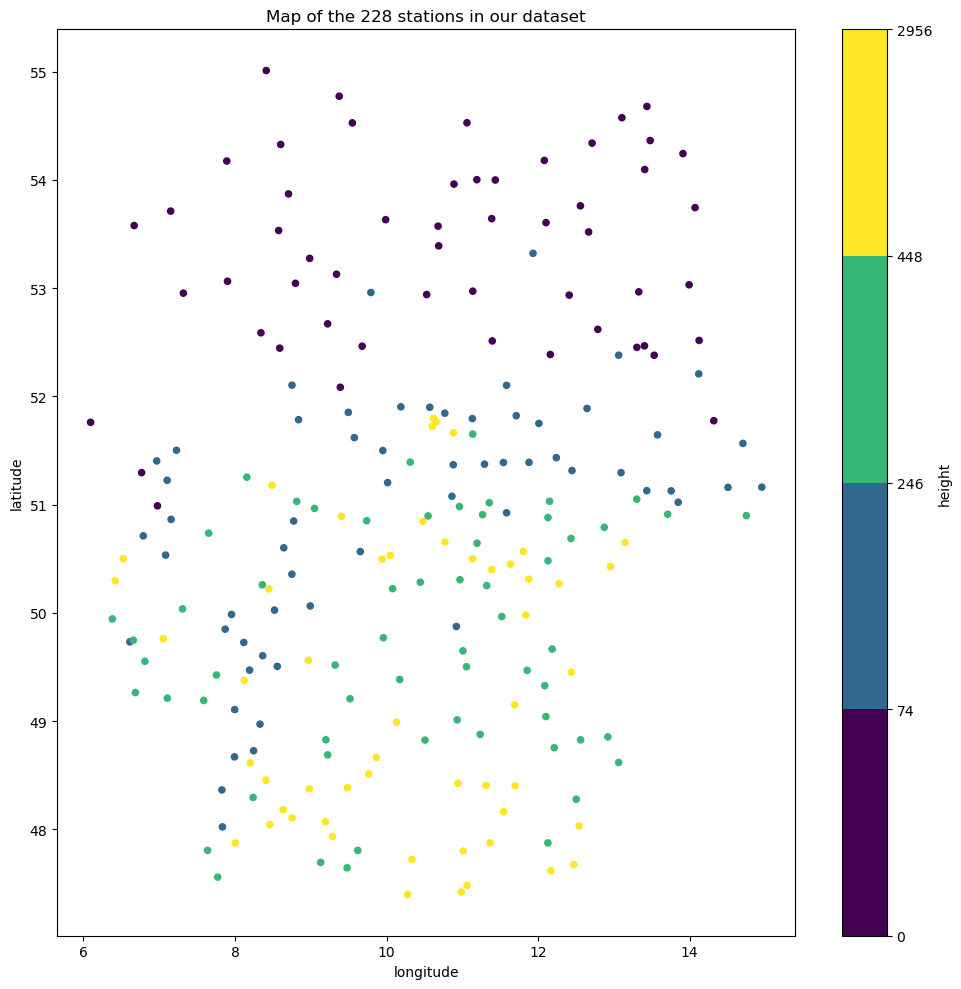

In [18]:
cmap = colormaps.get_cmap("viridis")
bounds = np.quantile(request.df.get_column("height"), [0, 0.25, 0.5, 0.75, 1])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)
plot = stations_final.plot.scatter(x="longitude", y="latitude", c="height", cmap=cmap, norm=norm, ax=ax)
title = "Map of the 228 stations in our dataset"
plot.set_title(title)
plt.show()

In [19]:
#values_final.head()
#values_final["value"].median()
#values_final["value"].mean()
#values_final["value"].max()
#values_final["value"].min()
values_final["value"].describe()

count    4.952486e+06
mean     2.167752e+00
std      4.852893e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e-01
75%      2.200000e+00
max      1.823000e+02
Name: value, dtype: float64

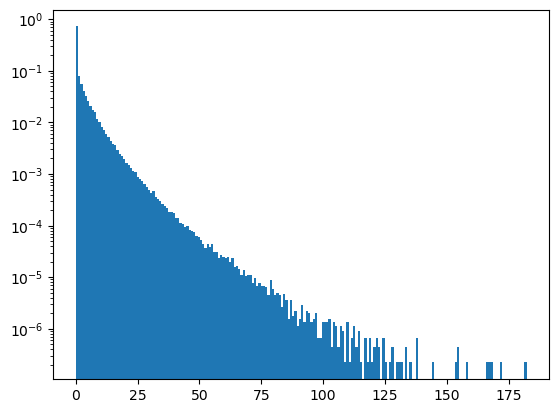

In [20]:
# histogram for rain amount each day
fig, ax = plt.subplots()
plt.yscale('log') # make y-axis log scale

n, bins, patches = ax.hist(values_final["value"], 200, density=True)

In [21]:
# amount of days with rain over 120
values_final[(values_final["value"]) > 125].shape

(23, 6)

<BarContainer object of 64 artists>

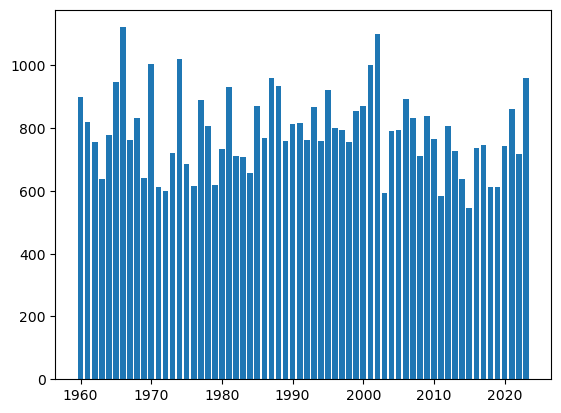

In [22]:
test = values_final[(values_final["station_id"]) == "00073"]
# test["value"].sort_values(ascending=True)

test_mean = test.groupby(test["date"].dt.year)["value"].sum()

fig, ax = plt.subplots()
ax.bar(test_mean.index, test_mean.values)

## 2)  Hypotheses:

News articles of my local newspaper suggest --> 1) amount or 2) reliable frequency (?) of rain in Germany is decreasing. Is this actually the case?

Why is this useful --> confirm that public percetpion of wheater/climate is correct or  the public perception is not quite factual and this analysis could shed light on how this might be the case.

### things to do (sketches):

- are we overinterpreting variance in wheater (short term) as trends in climate (long term --> 30 years?)?
- do we get lost in local variation and conclude an overall trend from that?
- there is probabily variation of amount of rain in each season --> did this change someway?
- did the amount of rain decrease significantly over the last years? (monthly average?)
- how is rainrall distributed? (log-normal?); did the disrtribution change? did the variance change? 
- did periods with extreme amount of (no) rain increase?
- Where August 22' (very dry) and August 23' (much rain) extremes? (opposites even --> so evidence for increase in variance, i.e. extreme weather?)
- Does (or did) the frequency of rain change with the season or over the years? --> e.g., less rainy days but same/less/more rain in total?
- Important local trends in global trend no longer observable?
- Development of absolute values of rain?